In [2]:
%qtconsole

In [1]:
import os
from os.path import expanduser
home = expanduser("~")
datap = os.path.join(home,'Documents','project','kagle','yelp','Data','raw')
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

/Users/cthorey/miniconda2/envs/yelp/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Data exploration

## The competition 

**In this competition, we are given photos that belong to a business and asked to predict the business attributes**

## A look in the different files

The training data consist of
- a folder containing the images - Each image have an id
- a csv file linking each image to its bussiness id
- a csv file linking each bussiness id to the corresponding labels

In [3]:
train = pd.read_csv(os.path.join(datap,'train.csv'))
train_photo_to_biz_ids = pd.read_csv(os.path.join(datap,'train_photo_to_biz_ids.csv'))
train_photo_to_biz_ids.photo_id = map(str,train_photo_to_biz_ids.photo_id)
test_photo_to_biz = pd.read_csv(os.path.join(datap,'test_photo_to_biz.csv'))

In [4]:
train.head(2)

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8


In [5]:
train_photo_to_biz_ids.head(2)

,photo_id,business_id
0,204149,3034
1,52779,2805


In the following, I gather everythin within the same pd dataframe for clarity

In [6]:
train_photos_names = os.listdir(os.path.join(datap,'train_photos'))
train_photos_paths = [os.path.join(datap,'train_photos',f) for f in train_photos_names]
train_photos_ids = [int(f.split('.')[0]) for f in train_photos_names]
train_photos = pd.DataFrame(
    np.array([train_photos_names,train_photos_paths,train_photos_ids]).T,
    columns =['photo_name','photo_path','photo_id'])
train_photos = pd.merge(train_photos,train_photo_to_biz_ids,on ='photo_id')
train_photos = pd.merge(train_photos,train, on = 'business_id')
train_photos.columns = list(train_photos.columns[:-1])+['labs']
train_photos = train_photos.dropna()
train_photos.index = range(len(train_photos))
def detect(i,labels):
        if str(i) in labels.split(' '):
            return 1
        else:
            return 0
val = [map(lambda x:detect(i,x), train_photos.labs) for i in range(9)]
df = pd.DataFrame(np.array(val).T,columns = ['label_'+str(i) for i in range(9)])
train_photos = train_photos.join(df)
train_photos.head()

,photo_name,photo_path,photo_id,business_id,labs,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8
0,10.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,10,242,0 2 5 6 8,1,0,1,0,0,1,1,0,1
1,100823.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,100823,242,0 2 5 6 8,1,0,1,0,0,1,1,0,1
2,100842.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,100842,242,0 2 5 6 8,1,0,1,0,0,1,1,0,1
3,101037.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,101037,242,0 2 5 6 8,1,0,1,0,0,1,1,0,1
4,101959.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,101959,242,0 2 5 6 8,1,0,1,0,0,1,1,0,1


 ## Exploration part 1 

Let's look at the distribution of pictures by restaurant

In [10]:
count_photo_by_business = train_photos.groupby('business_id').photo_id.count()

Instead of looking at numbers, we might plot the distribution

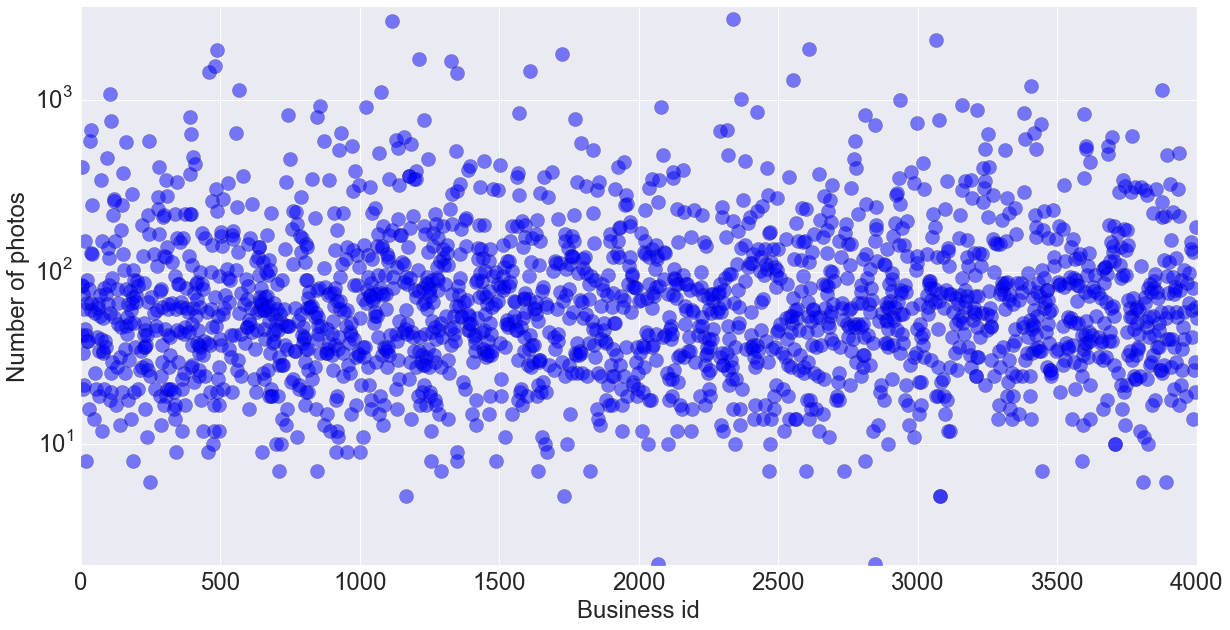

In [11]:
fig = plt.figure(figsize = (20,10))
ax = plt.subplot(111)
ax.scatter(count_photo_by_business.index,
            count_photo_by_business.values,
            marker = 'o',
            s= 200,
          alpha = 0.5)
ax.set_yscale('log')
ax.tick_params(labelsize = 24)
ax.set_xlim(0,max(count_photo_by_business.index))
ax.set_ylim(0,3500)
ax.set_ylabel('Number of photos',fontsize = 24)
ax.set_xlabel('Business id',fontsize = 24)

Therefore, the number of pictures by bussiness is preatty scattered. 

In [12]:
def return_pourcent_photo_below(x):
    y = np.sum(count_photo_by_business<x)/float(len(count_photo_by_business))
    print '%1.2f%% of the training example have less than %d photos'%(y*100,x)
    
return_pourcent_photo_below(10)
return_pourcent_photo_below(300)

1.65% of the training example have less than 10 photos
92.00% of the training example have less than 300 photos


Therefore, most of the business have between $20$ and $300$ photos. However, there are a few isntance with less than 10 pictures.

In [13]:
count_photo_by_business.sort_values().head(10)

business_id
2069    2
2846    2
1166    5
3080    5
3079    5
1733    5
3891    6
3809    6
247     6
2468    7
Name: photo_id, dtype: int64

## Exploration part 2

### Overlook 

In the above, we look at the distribution of pictures by bussiness. 
However, we have for each picture to predict a set of labels !

Indeed, for each picture, we can predict a set of 8 labels ! 

- 0: good_for_lunch
- 1: good_for_dinner 
- 2: takes_reservations
- 3: outdoor_seating
- 4: restaurant_is_expensive
- 5: has_alcohol
- 6: has_table_service
- 7: ambience_is_classy
- 8: good_for_kids

Then, at the end we have to predict for each bussiness a set of labels. There are 2000 bussiness in the dataset with varying numbers of pictures as seen above.

### Strategy one

- Build 8 classifiers, one for each label
- For each bussiness, we run our 8 classifiers on each picture of the corresponding bussiness dataset.
- Return the corresponding labels, on the basis of labels is ok if at least one is showing it.


### Strategy two

- Hot encoding of the labels combinations (512 labels)
- Train one classifier on this label encoding
- Pass the all the photo in the resulting classifier and then return all the labels ok

In [51]:
from sympy import binomial

print 'The number of combinations is for #2 %d'%(sum([binomial(9,x) for x in range(10)]))

The number of combinations is for #2 512


What are the number of pictures by labels ?

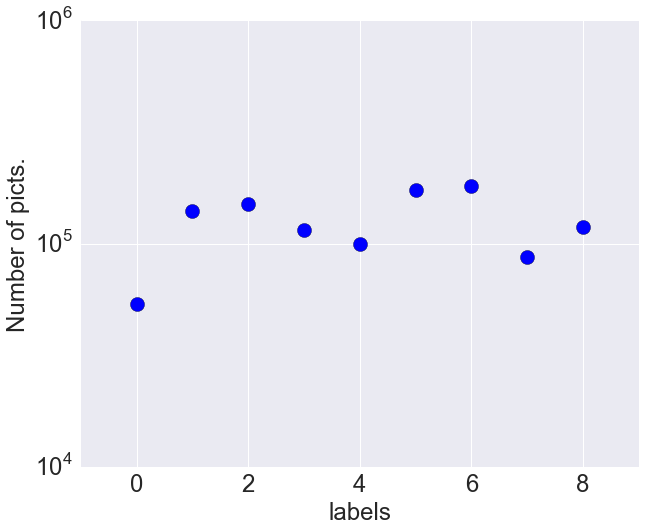

In [173]:
fig = plt.figure(figsize = (10,8))
ax =plt.subplot(111)
ax.scatter(range(9),[train_photos['label_'+str(i)].sum() for i in range(9)],
           marker = 'o',
           s=200)
ax.set_yscale('log')
ax.set_xlabel('labels',fontsize = 24)
ax.set_ylabel('Number of picts.',fontsize = 24)
ax.tick_params(labelsize=24)

Ok, they are pretty homogeneous, about $10^5$ instance for each labels

# Labels observation

Is there any labels that always come up together ?

In [23]:
print 'There is only %d combination of labels out of 512'%(len(set(train_photos.labs)))

There is only 172 combination of labels out of 512


In [27]:
label = train_photos[[f for f in train_photos.columns if f.split('_')[0] == 'label']]

# Train-val-test  split 

In [7]:
path = os.path.join(home,'Documents','project','kagle','yelp','Data','train-val-test')

def generate_train_val_test(path,train_photos):
    df = train_photos
    df = df.reindex(np.random.permutation(df.index))
    N = len(df)
    #Split for a test of 25%
    size_test = int(0.25*N)
    test = df.iloc[:size_test]
    train = df.iloc[size_test:]
    train.index = range(len(train))
    #Split for a train/Val 
    size_val = int(0.25*len(train))
    val = train.iloc[:size_val]
    train = train.iloc[size_val:]
    train.index = range(len(train))
    
    #Grab the file on disk
    istrain = os.path.isfile(os.path.join(path,'train.csv'))
    isval = os.path.isfile(os.path.join(path,'val.csv'))
    istest = os.path.isfile(os.path.join(path,'test.csv'))
    if istrain and isval and istest:  
        raise ValueError('ATTENTION: des fichiers train/val/test existe deja!!!!!!! Remove them before going further if you wish !!!')

    train.to_csv(os.path.join(path,'train.csv'), index= None)
    test.to_csv(os.path.join(path,'test.csv'), index = None)
    val.to_csv(os.path.join(path,'val.csv'),index= None)

def load_df_train_val():
    train = pd.read_csv(os.path.join(path,'train.csv'))
    val = pd.read_csv(os.path.join(path,'val.csv'))
    return train, val

In [31]:
generate_train_val_test(path,train_photos)

ValueError: ATTENTION: des fichiers train/val/test existe deja!!!!!!! Remove them before going further if you wish !!!

In [32]:
train,val = load_df_train_val()

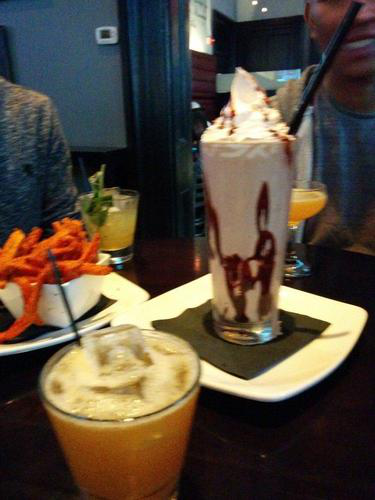

In [33]:
PIL.Image.open(train.photo_path.iloc[4328])

In [38]:
from skimage.io import imread

In [52]:
img = imread(train.photo_path.iloc[4328])

In [51]:
ilg.shape

(500, 375, 3)

In [53]:

from skimage.transform import resize

In [60]:
[f for f in train.columns if f.split('_')[0] == 'label']

['label_0',
 'label_1',
 'label_2',
 'label_3',
 'label_4',
 'label_5',
 'label_6',
 'label_7',
 'label_8']

In [59]:
train[[f for f in train.columns if f.split('_')[0] == 'label']]

,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8
0,0,1,1,1,1,1,1,0,0
1,0,1,1,1,1,1,1,0,0
2,0,1,0,0,0,1,1,1,0
3,0,1,1,0,1,1,1,0,0
4,0,0,1,1,1,1,1,0,1
5,0,1,1,0,1,1,1,1,0
6,1,0,0,1,0,1,1,0,1
7,0,1,1,1,1,1,1,1,0
8,1,0,0,0,0,0,0,0,1
9,1,0,0,1,0,0,0,0,1


In [55]:
from skimage.transform import resize

In [56]:
            img = resize(img, (args.size, args.size))
            img = img.transpose(2, 0, 1)
            img = img.astype(np.float32)

            assert img.shape == (3, args.size, args.size)
            assert img.dtype == np.float32

NameError: name 'args' is not defined

In [34]:
train

,photo_name,photo_path,photo_id,business_id,labs,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8
0,235998.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,235998,487,1 2 3 4 5 6,0,1,1,1,1,1,1,0,0
1,132982.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,132982,3240,1 2 3 4 5 6,0,1,1,1,1,1,1,0,0
2,403446.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,403446,1015,1 5 6 7,0,1,0,0,0,1,1,1,0
3,446073.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,446073,2339,1 2 4 5 6,0,1,1,0,1,1,1,0,0
4,383331.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,383331,3435,2 3 4 5 6 8,0,0,1,1,1,1,1,0,1
5,310208.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,310208,2611,1 2 4 5 6 7,0,1,1,0,1,1,1,1,0
6,323811.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,323811,976,0 3 5 6 8,1,0,0,1,0,1,1,0,1
7,19818.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,19818,1724,1 2 3 4 5 6 7,0,1,1,1,1,1,1,1,0
8,213523.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,213523,1387,0 8,1,0,0,0,0,0,0,0,1
9,130711.jpg,/Users/cthorey/Documents/project/kagle/yelp/Da...,130711,1386,0 3 8,1,0,0,1,0,0,0,0,1
